# Introduction

In this project, I build a neural network to evaluate the CIFAR-10 dataset. Then, I compare my accuracy to that of a fictcious model from a company that achieves 70%, to see if it is worthwhile 'buying' their model or using this 'in-house' model.



In [1]:
## Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset


In [2]:
# Create training set and testing set

trainset = torchvision.datasets.CIFAR10('data', 
                                        train=True,
                                        download=True, 
                                        transform=transforms.ToTensor())

testset = torchvision.datasets.CIFAR10('data', 
                                        train=False,
                                        download=True, 
                                        transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size=250
# Create training loader and testing loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [4]:
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, I explore the dimensions of the data.
The function defined below takes a data loader as an argument. I change the transforms to view the images.

In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

In [6]:
image, label = trainset[0]
image_shape=image.shape
image_shape # 3 color channel, 32x32 pixels

torch.Size([3, 32, 32])

deer


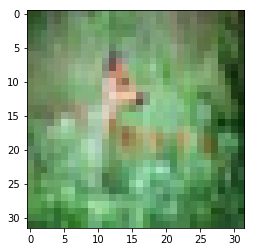

ship


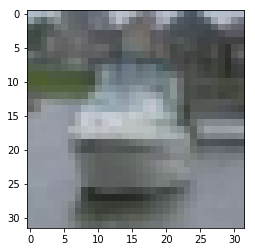

deer


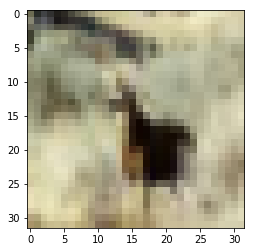

bird


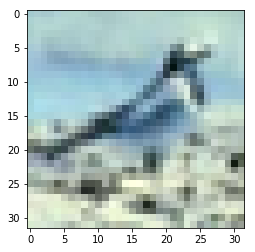

truck


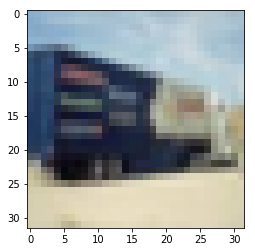

In [7]:
show5(trainloader)

## Building the Neural Network
I use the layers in `torch.nn` and the `torch.nn.functional` module (imported as `F`) to construct a neural network based on the parameters of the dataset. 

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1536)
        self.fc2 = nn.Linear(1536, 768)
        self.fc3 = nn.Linear(768, 384)
        self.fc4 = nn.Linear(384, 128)
        self.fc5 = nn.Linear(128, output_size)
        
    def forward(self, x):
        # Flatten images into vectors
        x = x.view(x.size(0), -1)
        # Apply layers & activation functions
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

I specify a loss function and an optimizer, and instantiate the model.

In [9]:
input_size = 3*32*32
output_size = 10

model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Testing the model
Using the previously created `DataLoader` for the test set, I compute the percentage of correct predictions using the highest probability prediction. 

I run this on the GPU for the Udacity course since the model is computationally intensive.


In [10]:
training_on_gpu = torch.cuda.is_available()

if not training_on_gpu:
    print('CUDA is unavailable. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

CUDA is available. Training on GPU


In [11]:
epochs = 30
steps = 0

train_losses, test_losses, accuracy_tracking = [], [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracy_tracking.append(accuracy/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 2.224..  Test Loss: 2.143..  Test Accuracy: 0.222
Epoch: 2/30..  Training Loss: 2.011..  Test Loss: 2.005..  Test Accuracy: 0.271
Epoch: 3/30..  Training Loss: 1.892..  Test Loss: 1.802..  Test Accuracy: 0.350
Epoch: 4/30..  Training Loss: 1.821..  Test Loss: 1.865..  Test Accuracy: 0.321
Epoch: 5/30..  Training Loss: 1.764..  Test Loss: 1.800..  Test Accuracy: 0.342
Epoch: 6/30..  Training Loss: 1.711..  Test Loss: 1.665..  Test Accuracy: 0.397
Epoch: 7/30..  Training Loss: 1.682..  Test Loss: 1.635..  Test Accuracy: 0.407
Epoch: 8/30..  Training Loss: 1.652..  Test Loss: 1.621..  Test Accuracy: 0.413
Epoch: 9/30..  Training Loss: 1.605..  Test Loss: 1.606..  Test Accuracy: 0.422
Epoch: 10/30..  Training Loss: 1.581..  Test Loss: 1.694..  Test Accuracy: 0.406
Epoch: 11/30..  Training Loss: 1.553..  Test Loss: 1.501..  Test Accuracy: 0.460
Epoch: 12/30..  Training Loss: 1.530..  Test Loss: 1.630..  Test Accuracy: 0.434
Epoch: 13/30..  Training Loss: 1.509.

I plot the training loss and validation loss

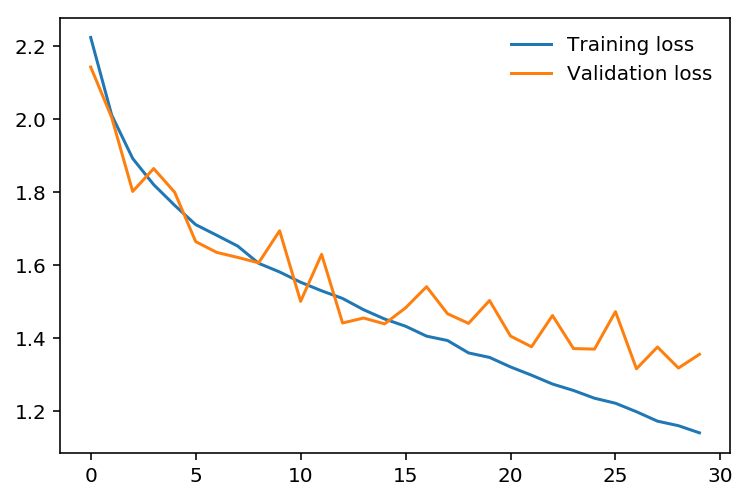

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

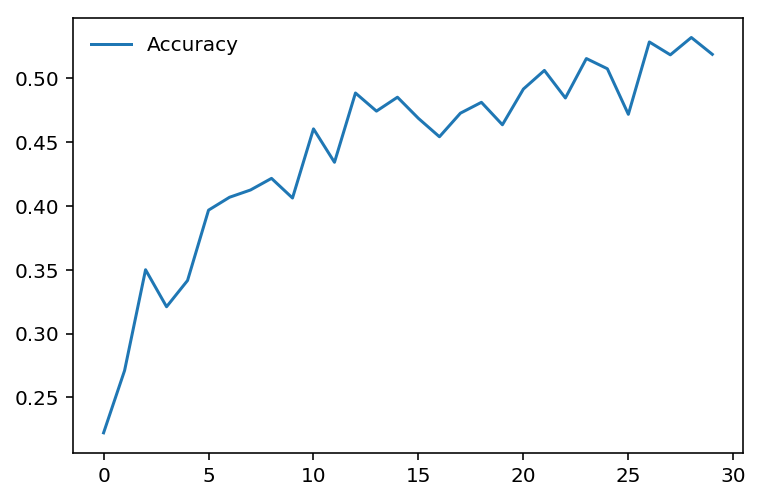

In [13]:
plt.plot(accuracy_tracking, label='Accuracy')
plt.legend(frameon=False)

## Saving the model
I use `torch.save`to save the model for future loading.

In [14]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (fc1): Linear(in_features=3072, out_features=1536, bias=True)
  (fc2): Linear(in_features=1536, out_features=768, bias=True)
  (fc3): Linear(in_features=768, out_features=384, bias=True)
  (fc4): Linear(in_features=384, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias'])


In [15]:
torch.save(model.state_dict(), 'cifar10_accuracy_low50s.pth')

## Model Recommendation


#### Recommendation:
I recommend that we buy Detectocorp's model. 

The model I have created acheived about a 50% accuracy. The testing loss and validation loss began to diverge around 15 of 30 epochs with an accuracy of 45%, so my model overfits to some extent. 

My model's 50% accuracy is weak relative to Detectocorp's 70% and both are worse than the more adanced solutions in the literature of 90% plus. 

My model is a simple application of deep learning to image classification. I simply converted my images to tensors rather than specifying a more complication transformation with normalization, etc. Pursuing these more compliated transformation could improve accuracy. 

My model has 5 layers, starting with an input of 3072 (3x32x32 from the tensor dimensions) and reducing down to the 10 outputs, one for each class of image. Each layer utilizes a rectified linear unit function. I specified a cross entropy loss function and utilized stochastic gradient descent with a learning rate of 0.1. The model could be improved with a more granular learning rate (for example 0.01, 0.001, ...), but this would involve more computational power. 

NOTE: For this project, I utilized code from the various notebooks from the intro to pytorch Udacity module 